# Evaluate

This notebook evaluates the network trained previous notebooks and analyzes the results.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%cd ..
%load_ext autoreload
%autoreload 2

C:\Users\Minjae\Desktop\EEG_Project


In [2]:
# Load some packages
import os
from copy import deepcopy
import hydra
from omegaconf import OmegaConf
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pprint
import matplotlib.pyplot as plt

# custom package
from datasets.caueeg_script import build_dataset_for_train
import models
from train.evaluate import check_accuracy
from train.evaluate import check_accuracy_extended
from train.evaluate import check_accuracy_extended_debug
from train.evaluate import check_accuracy_multicrop
from train.evaluate import check_accuracy_multicrop_extended
from train.visualize import draw_roc_curve
from train.visualize import draw_confusion
from train.visualize import draw_error_table

In [3]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.11.0+cu113
cuda is available.


-----

## Load the configuration used during the train phase

In [4]:
model_name = '4tqv22h2'
model_path = os.path.join('local/checkpoint_temp', model_name, 'last_checkpoint.pt')

ckpt = torch.load(model_path, map_location=device)
print(ckpt.keys())

dict_keys(['model_state', 'config', 'optimizer_state', 'scheduler_state'])


In [5]:
model_state = ckpt['model_state']
config = ckpt['config']
optimizer = ckpt['optimizer_state']
scheduler = ckpt['scheduler_state']

In [6]:
pprint.pprint(config, width=250)

{'EKG': 'X',
 '_target_': 'models.vgg_2d.VGG2D',
 'activation': 'relu',
 'age_mean': tensor([71.1643], device='cuda:0'),
 'age_std': tensor([9.9056], device='cuda:0'),
 'awgn': 0.0010567535080937109,
 'awgn_age': 0.04905029424956587,
 'base_lr': 0.0002811706625951745,
 'batch_norm': True,
 'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'criterion': 'cross-entropy',
 'crop_multiple': 4,
 'crop_timing_analysis': False,
 'cwd': '/home/imkbsz/workspace/eeg_analysis',
 'dataset_name': 'CAUEEG dataset',
 'dataset_path': 'local/dataset/02_Curated_Data_220419/',
 'ddp': True,
 'ddp_size': 3,
 'device': 0,
 'draw_result': True,
 'dropout': 0.20516529342464968,
 'fc_stages': 2,
 'file_format': 'memmap',
 'in_channels': 40,
 'input_norm': 'dataset',
 'iterations': 72917,
 'latency': 2000,
 'load_event': False,
 'lr_scheduler_type': 'cosine_decay_with_warmup_one_and_half',
 'mgn': 0.0669700303853294,
 'minibatch': 160,
 'mixup

-----

## Load the target model

In [7]:
# model = config['generator'](**config).to(device)
model = hydra.utils.instantiate(config).to(device)

if config.get('ddp', False):
    model_state_ddp = deepcopy(model_state)
    model_state = OrderedDict()
    for k, v in model_state_ddp.items():
        name = k[7:] # remove 'module.' of DataParallel/DistributedDataParallel
        model_state[name] = v
    model.load_state_dict(model_state)
else:
    model.load_state_dict(model_state)

-----

## Evaluate the model and analyze the performance by the crop timing

### Configurations

In [10]:
config = ckpt['config']

config.pop('cwd', 0)
config['ddp'] = False
config['crop_timing_analysis'] = True
config['eval'] = True
config['device'] = device

repeat = round(200 / config['crop_multiple'])
print(repeat)

50


### Build Dataset

In [11]:
train_loader, val_loader, test_loader, multicrop_test_loader = build_dataset_for_train(config, verbose=True)

transform: Compose(
    EegRandomCrop(crop_length=4000, length_limit=10000000, multiple=4, latency=2000, return_timing=True)
    EegDropChannels(drop_index=[19])
    EegToTensor()
)

----------------------------------------------------------------------------------------------------

transform_multicrop: Compose(
    EegRandomCrop(crop_length=4000, length_limit=10000000, multiple=8, latency=2000, return_timing=True)
    EegDropChannels(drop_index=[19])
    EegToTensor()
)

----------------------------------------------------------------------------------------------------


task config:
{'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'task_description': 'Classification of [Normal], [MCI], and [Dementia] '
                     'symptoms.',
 'task_name': 'CAUEEG-task2 benchmark'}

 ---------------------------------------------------------------------------------------------------- 

train_dataset[0].keys():
dict_keys

### Train set

In [12]:
_ = check_accuracy_extended_debug(model, train_loader, 
                                  config['preprocess_test'], config, repeat=repeat)
train_acc = _[0] 
train_score = _[1]
train_target = _[2]
train_confusion = _[3]
train_error_table = _[4]
train_crop_timing = _[5]

print(train_acc)

67.67173913043479


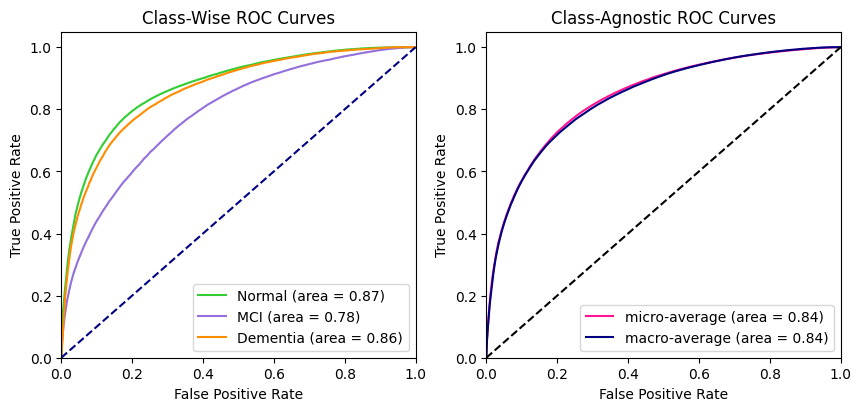

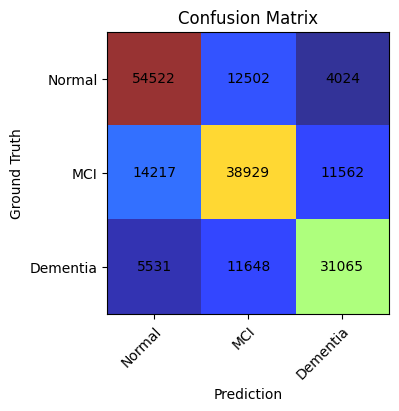

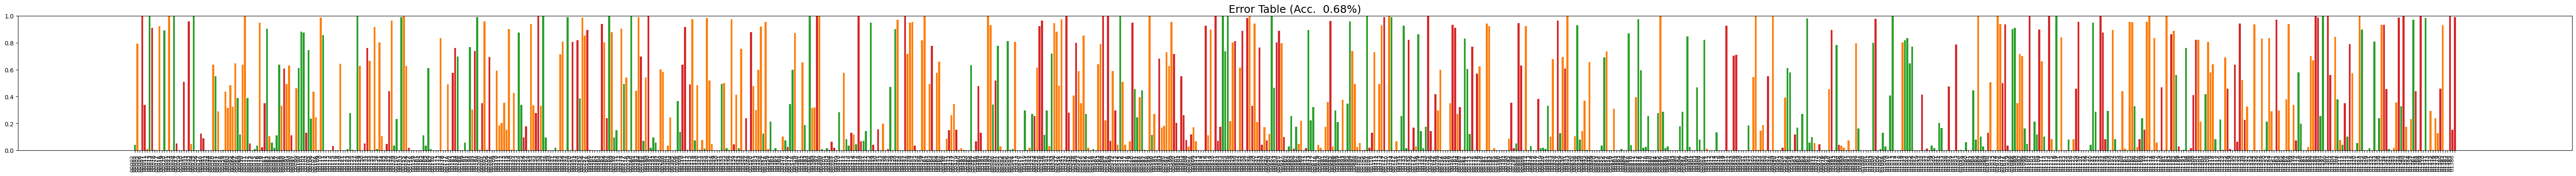

In [13]:
draw_roc_curve(train_score, train_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(train_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(train_error_table, use_wandb=False, fig_size=(60.0, 4.0))

### Validation set

In [14]:
_ = check_accuracy_extended_debug(model, val_loader, 
                                  config['preprocess_test'], config, repeat=repeat)
val_acc = _[0]
val_score = _[1]
val_target = _[2]
val_confusion = _[3]
val_error_table = _[4]
val_crop_timing = _[5]

print(val_acc)

61.59243697478992


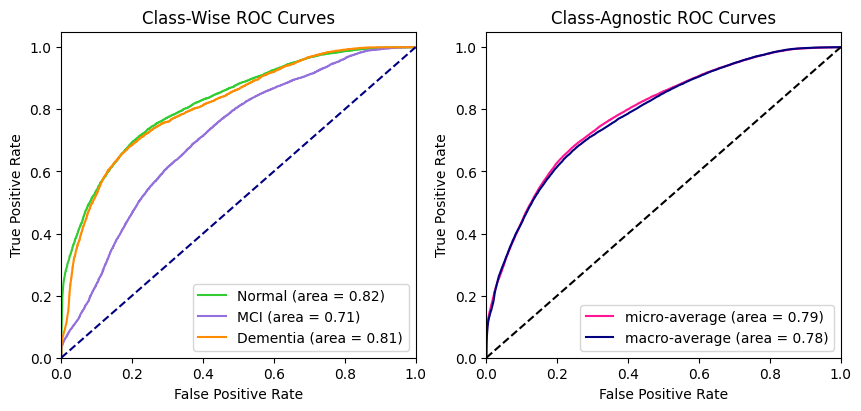

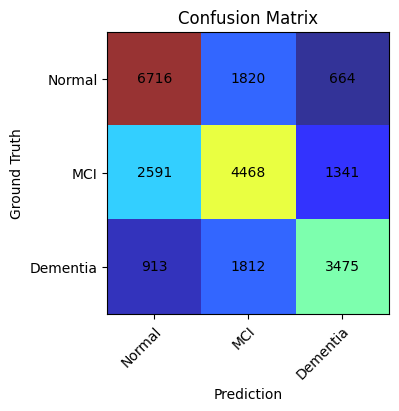

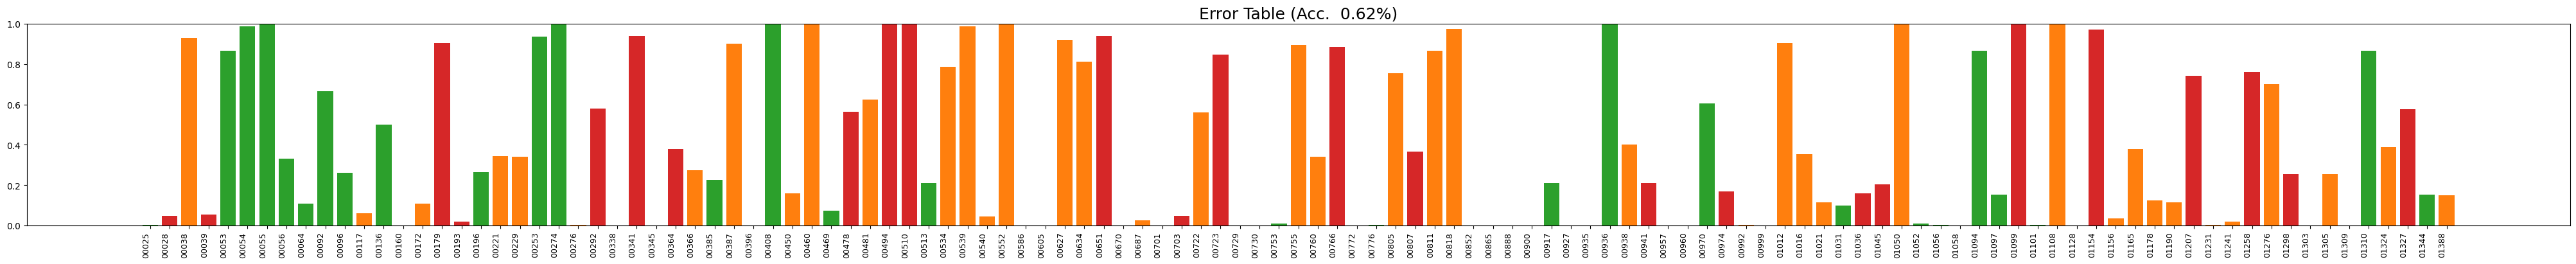

In [15]:
draw_roc_curve(val_score, val_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(val_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(val_error_table, use_wandb=False)

### Test set

In [16]:
_ = check_accuracy_extended_debug(model, test_loader, 
                                  config['preprocess_test'], config, repeat=repeat)
test_acc = _[0]
test_score = _[1]
test_target = _[2]
test_confusion = _[3]
test_error_table = _[4]
test_crop_timing = _[5]

print(test_acc)

59.567796610169495


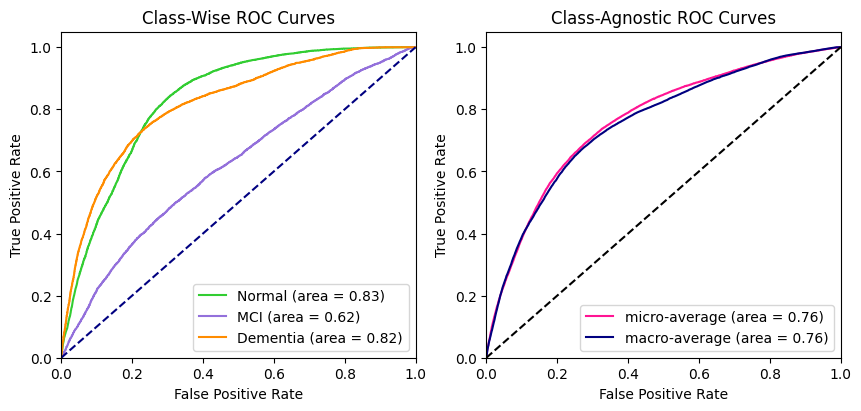

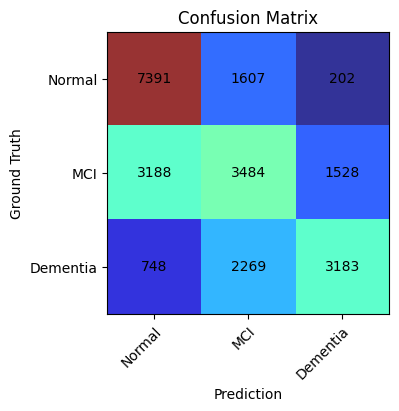

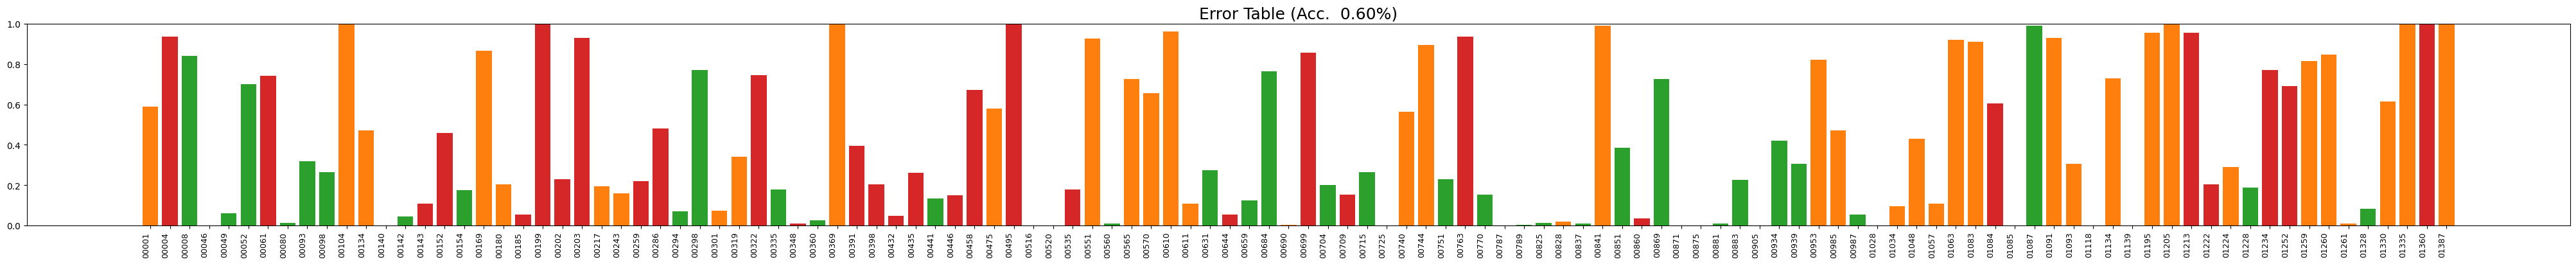

In [17]:
draw_roc_curve(test_score, test_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(test_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(test_error_table, use_wandb=False)

### Test set (with test-time augmentation)

In [18]:
_ = check_accuracy_multicrop_extended(model, multicrop_test_loader, 
                                      config['preprocess_test'], config, repeat=repeat)
multi_test_acc = _[0]
multi_test_score = _[1]
multi_test_target = _[2]
multi_test_confusion = _[3]
multi_test_error_table = _[4]

print(multi_test_acc)

62.186440677966104


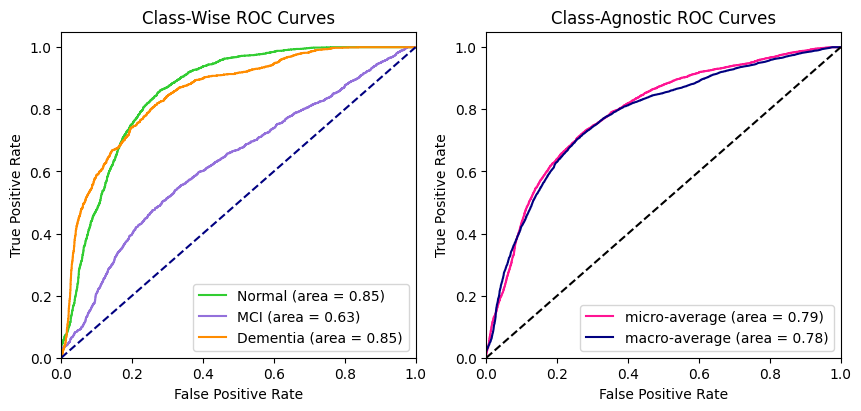

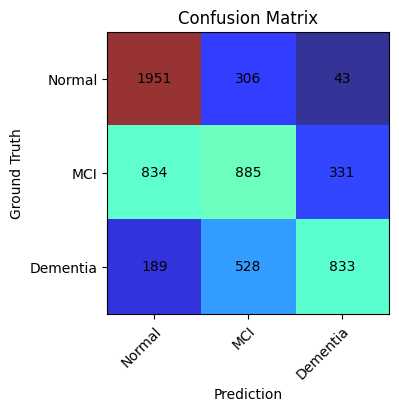

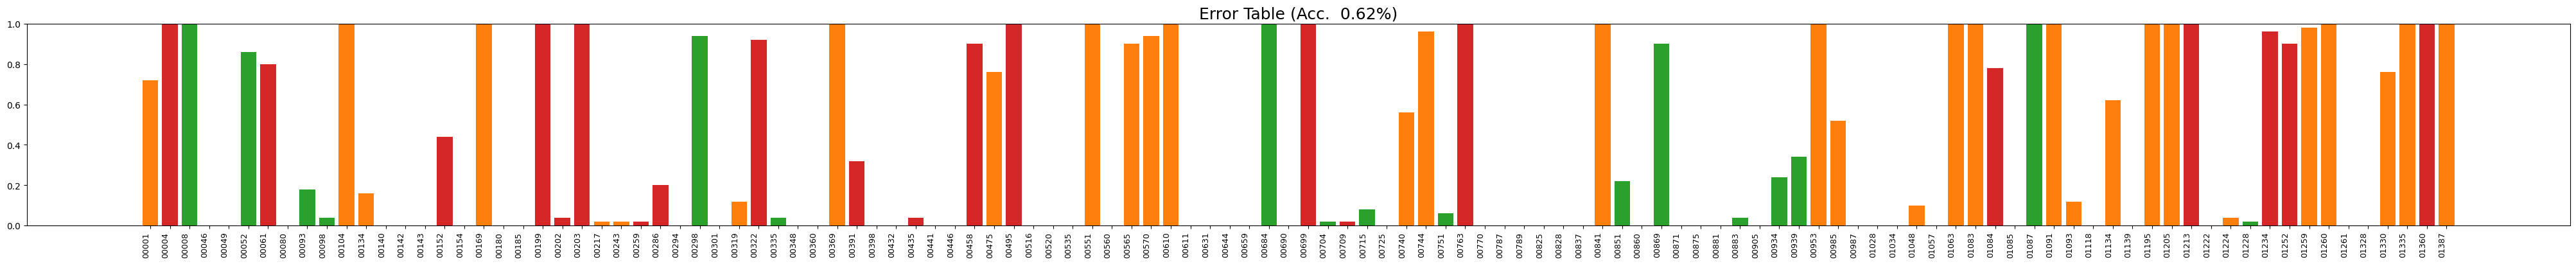

In [19]:
draw_roc_curve(multi_test_score, multi_test_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(multi_test_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(multi_test_error_table, use_wandb=False)

### Examine whether the model has a bias related to the cropping starting time

In [20]:
train_pos = []
train_neg = []

for k, v in train_crop_timing.items():
    for i in range(v.get('correct', 0)):
        train_pos.append(k)
    for i in range(v.get('incorrect', 0)):
        train_neg.append(k)

##

val_pos = []
val_neg = []

for k, v in val_crop_timing.items():
    for i in range(v.get('correct', 0)):
        val_pos.append(k)
    for i in range(v.get('incorrect', 0)):
        val_neg.append(k)

##

test_pos = []
test_neg = []

for k, v in test_crop_timing.items():
    for i in range(v.get('correct', 0)):
        test_pos.append(k)
    for i in range(v.get('incorrect', 0)):
        test_neg.append(k)

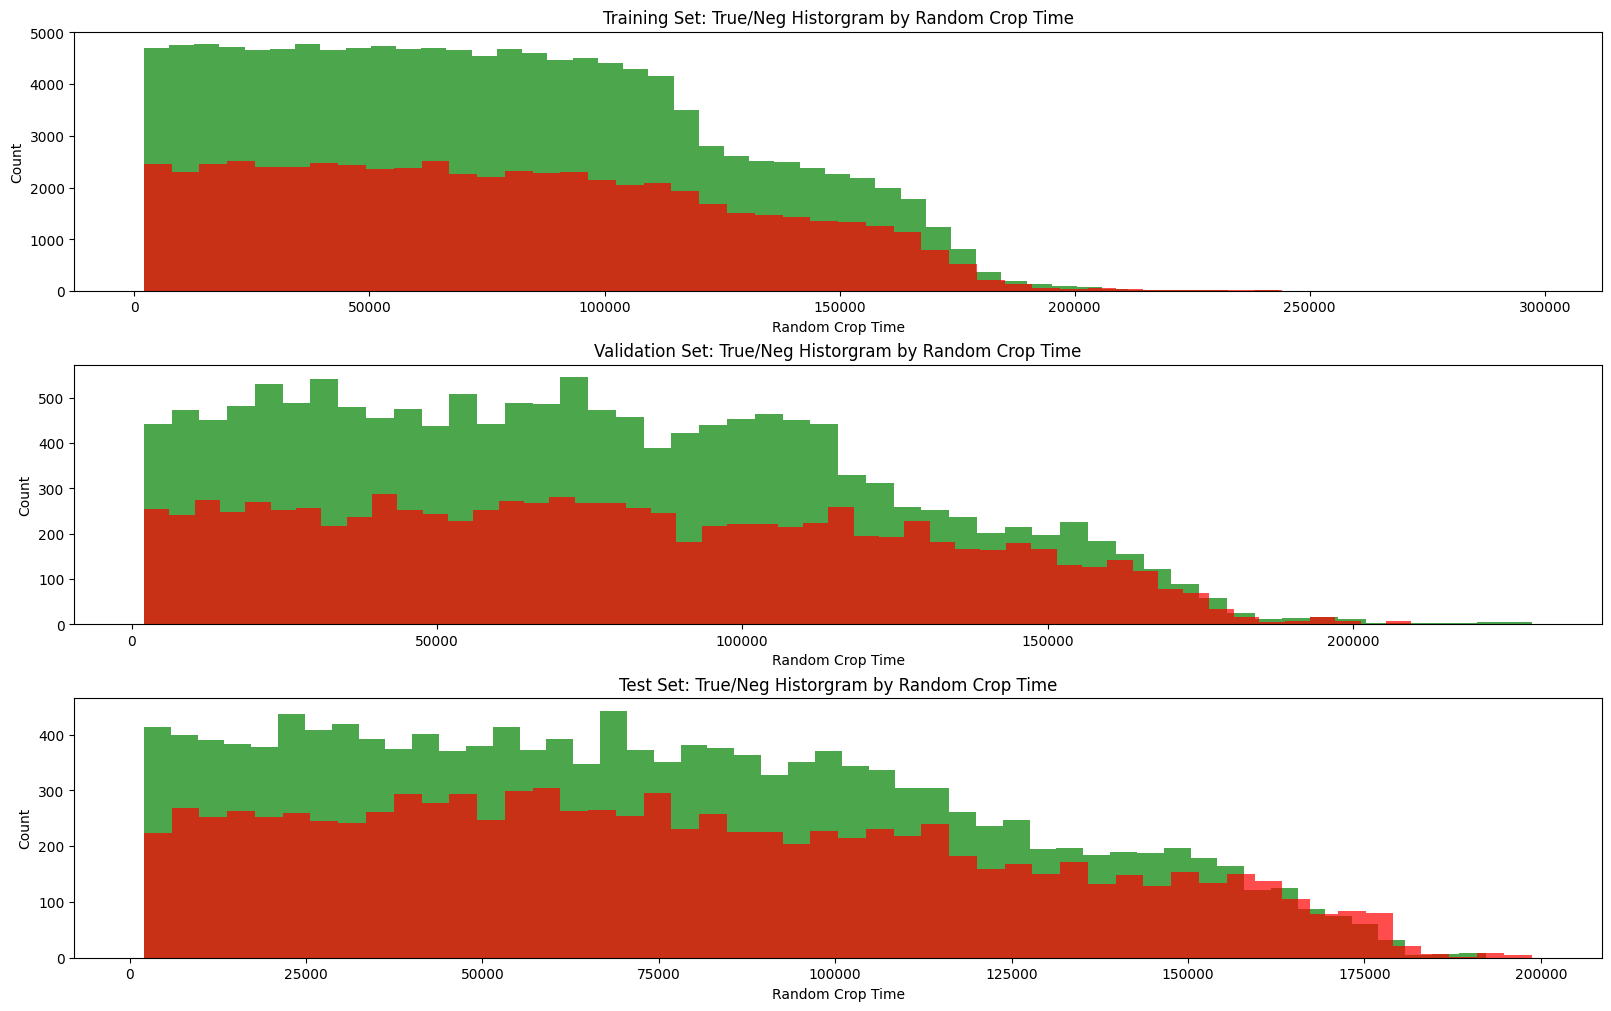

In [21]:
fig = plt.figure(num=1, clear=True, figsize=(16, 10), constrained_layout=True)
n_bins = 50
density = False

ax = fig.add_subplot(3, 1, 1)
ax.hist(train_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(train_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Training Set: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

ax = fig.add_subplot(3, 1, 2)
ax.hist(val_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(val_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Validation Set: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

ax = fig.add_subplot(3, 1, 3)
ax.hist(test_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(test_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Test Set: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

plt.show()
fig.clear()
plt.close(fig)

-----

## Evaluate the model with length limit

### Configurations

In [22]:
config = ckpt['config']

config['crop_timing_analysis'] = False
config['signal_length_limit'] = 200 * 60 * 7  # 7 minutes
config['eval'] = True
config['device'] = device

repeat = round(50 / config['crop_multiple'])

train_loader, val_loader, test_loader, multi_test_loader = build_dataset_for_train(config, verbose=False)

In [23]:
# train
train_acc = check_accuracy(model, train_loader, 
                           config['preprocess_test'], config, repeat=repeat)
val_acc = check_accuracy(model, val_loader, 
                         config['preprocess_test'], config, repeat=repeat)
test_acc = check_accuracy(model, test_loader, 
                          config['preprocess_test'], config, repeat=repeat)
multi_test_acc = check_accuracy_multicrop(model, multi_test_loader, 
                                          config['preprocess_test'], config, repeat=repeat)

print(train_acc, val_acc, test_acc, multi_test_acc)

67.42980072463769 60.32913165266106 58.38629943502825 62.570621468926554
